Problem Statement: 

The volatile nature of financial markets impose various sources of uncertainty on an investor's portfolio. The options market provides a way for investors to combat those uncertainties, by hedging their portfolio against the risk of adverse price movements. We will compare the performance of analytical pricing models with results from various simulation techniques, to determine the best method for pricing option contracts. 


Objective:

The objective of this project is to compare the performance of analytical pricing models with results from various simulation techniques, to determine the best method for pricing option contracts.

Data Collection: 

We have obtained data from Yahoo Finance for the following 

In [2]:
import re
import datetime as dt 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from IPython.display import display
from tqdm import tqdm
import sqlite3 as sql 
from scipy.optimize import minimize
import scipy.stats as st 
%matplotlib inline


Standard Brownian Motion: 

- A standard Brownian motion is a random process  $x = \{X_t : t \isin [0,\infin]\}$ with a state space $\real$ that satisfies the following properties. 

1. $X_0 = 0$ with probability 1. 
   1. 100% probability that the initial value of the process is 0.
2. $X$ has stationary increments. That is for $s, t \isin [0, \infin]$ with $s < t$, the random variable $X_t - X_s$ has the same distribution as $X_{t-s}$. 
   1. The increments of the process are independent and identically distributed.
3. $X$ has independent increments. Thast is for, $t_1, t_2, ..., t_n \isin [0, \infin)$ with $t_1 < t_2 < ... < t_n$, the random variables $X_{t_1}, X_{t_2}, ..., X_{t_n}$ are independent. 
   1. The increments of the process are independent.
4. $X_t$ is normally distributed with mean 0 and variance $t$. 
   1. The increments of the process are normally distributed with mean 0 and variance $t$.
5. With probability 1, $t \rightarrow X_t$ is continuous on $[0, \infin)$


## Demo of Brownian Motion

details found here: [Brownian Motion](https://towardsdatascience.com/brownian-motion-with-python-9083ebc46ff0)


## Geometric Brownian Motion (GBM) is a **continuious-time** stochastic process 

Suppose that $z = \{ Z_t: t \isin [0, \infin]\}$ is a Standard Brownian Motion, and that $\mu \isin \real \  \& \ \sigma \isin (0, \infin)$:

$$X_t = \exp\left[\left(\mu - \frac{\sigma^2}{2}\right) t + \sigma Z_t\right], \quad t \in [0, \infty)$$

The Stochastic Process $x = \{X_t : t \isin [0,\infin]\}$
- in which the logarithim of the randomly varying quantity follows a Browniuan Motion (Wiener proccess) with a drift. 
- Dynamics are controlled by the mean and variance parameters of the underlying Normal Distribution. This emulates the grownth and the 'volatility'  of the underlying stock. 

---

In [3]:
class Brownian():
    """
    A Brownian motion class constructor
    """
    def __init__(self,x0=0):
        """
        Init class
        """
        assert (type(x0)==float or type(x0)==int or x0 is None), "Expect a float or None for the initial value"
        
        self.x0 = float(x0)
    
    def gen_random_walk(self,n_step=100):
        """
        Generate motion by random walk
        
        Arguments:
            n_step: Number of steps
            
        Returns:
            A NumPy array with `n_steps` points
        """
        # Warning about the small number of steps
        if n_step < 30:
            print("WARNING! The number of steps is small. It may not generate a good stochastic process sequence!")
        
        w = np.ones(n_step)*self.x0
        
        for i in range(1,n_step):
            # Sampling from the Normal distribution with probability 1/2
            yi = np.random.choice([1,-1])
            # Weiner process
            w[i] = w[i-1]+(yi/np.sqrt(n_step))
        
        return w
    
    def gen_normal(self,n_step=100):
        """
        Generate motion by drawing from the Normal distribution
        
        Arguments:
            n_step: Number of steps
            
        Returns:
            A NumPy array with `n_steps` points
        """
        if n_step < 30:
            print("WARNING! The number of steps is small. It may not generate a good stochastic process sequence!")
        
        w = np.ones(n_step)*self.x0
        
        for i in range(1,n_step):
            # Sampling from the Normal distribution
            yi = np.random.normal()
            # Weiner process
            w[i] = w[i-1]+(yi/np.sqrt(n_step))
        
        return w
    
    def stock_price(
                    self,
                    s0=100,
                    mu=0,
                    sigma=.1,
                    deltaT=25,
                    dt=0.1
                    ):
        """
        Models a stock price S(t) using the Weiner process W(t) as
        `S(t) = S(0).exp{(mu-(sigma^2/2).t)+sigma.W(t)}`
        
        Arguments:
            s0: Iniital stock price, default 100
            mu: 'Drift' of the stock (upwards or downwards), default 1
            sigma: 'Volatility' of the stock, default 1
            deltaT: The time period for which the future prices are computed, default 52 (as in 52 weeks)
            dt (optional): The granularity of the time-period, default 0.1
        
        Returns:
            s: A NumPy array with the simulated stock prices over the time-period deltaT
        """
        n_step = int(deltaT/dt)
        time_vector = np.linspace(0,deltaT,num=n_step)
        # Stock variation
        stock_var = (mu-(sigma**2/2))*time_vector
        # Forcefully set the initial value to zero for the stock price simulation
        self.x0=0
        # Weiner process (calls the `gen_normal` method)
        weiner_process = sigma*self.gen_normal(n_step)
        # Add two time series, take exponent, and multiply by the initial stock price
        s = s0*(np.exp(stock_var+weiner_process))
        
        return s


To simulate the stock price: 

$$S(t) = S(0) \ e^{(\mu - \frac{\sigma ^2}{2})t + \sigma W(t)}, \quad t ≥ 0$$

- For example, a stock with a postive grownth trend will have a postive mean. For this particular simulation the choice of the mean is .2 and standard deviation is .68
  


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


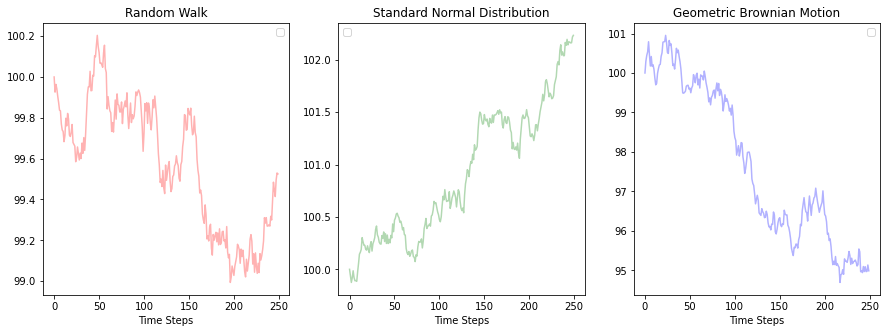

In [25]:
x0 = 100 # initial value
ts = 250 # time steps
n = 1 # number of simulations

s0 = x0 # initial stock price
mu = 0.0 # drift
sigma = .03 # volatility

b = Brownian(x0)
random_walk = np.array([b.gen_normal(ts) for i  in range(n)])
normal_sim = np.array([b.gen_normal(ts) for i  in range(n)])
stock_sim = np.array([b.stock_price(s0,mu, sigma) for i in range(n)])

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(random_walk.T, alpha=0.3, color = 'red')
ax[0].set_title('Random Walk')
ax[1].plot(normal_sim.T, alpha=0.3, color = 'green')
ax[1].set_title('Standard Normal Distribution')
ax[2].plot(stock_sim.T, alpha=0.3, color = 'blue')
ax[2].set_title('Geometric Brownian Motion')

for a in ax: 
    a.set_xlabel('Time Steps')
    a.legend()
plt.show()

fig.savefig('brownian.png')

__The Black Scholes model is a differential equation that is widely used to price option contracts.__


# Monte carlo simulation on the Black-scholes model: 

[Page](https://kinder-chen.medium.com/black-scholes-model-and-monte-carlo-simulation-d8612ac4519b)

- The Black-Scholes model is a partial differential equation that is widely used to price option contracts.

**Europen Call Option:**

$$C(S,t) = N(d_1)S_t - N(d_2)Ke^{-rt} \\ \text{where: } d_1 =  (ln(\frac{S_t}{K}) + t(r+\frac{\sigma^2}{2})) \frac{1}{\sigma \sqrt{t}} \\ \text{and: } d_2 = d_1 - \sigma \sqrt{t}$$

-> The Seven Inputs Needed are: 
  - $C$ = Call option Price
  - $N$ = CDF of Normal Distribution 
  - $K$ = Strike Price of the contract 
  - $S_t$ = Spot Price of an asset
  - $r$ = risk-free interest rate
  - $t$ = time to maturity 
  - $\sigma$ = volatility of an asset
  - $e^{-rt}$ = Time Decay 

**European Put Option:**

$$P(S, t) = Ke^{-rt} - S_t + C(S_t, t) \\ = N(-d_2) K e^{-r(T-t)} - N(-d_1) S_t$$

$$\text{where: } d_1 = \frac{ (ln(\frac{S_t}{K}) + (T-t)(r+\frac{\sigma^2}{2})) }{\sigma \sqrt{(T-t)}} \\ \ \\ \text{and: } d_2 = d_1 - \sigma \sqrt{(T-t)}$$

---- 

The underlying stock follows the Goemetric Brownian Motion, and satisfies the following stochastic differential equation:
$$dS_t = \mu S_t dt + \sigma S_t dW_t$$

- With $\mu$ is the drift rate of grownth of the stock, and W denotes a Weiner process (one dimensional brownian motion).
- The analytic solution of the SDE can be solved as: 
$$S_t = S_0 e^{(\mu - \frac{\sigma^2}{2})t + \sigma \sqrt{t}Z}$$

- Where $Z$ is a standard normal random variable. 
- Model assumes prices follow a lognormal distribution. Asset prices are often observed to have significant right skewness have higher likelihood of being observed at lower asset prices. 


--- 
## Simulate the option price with **multiple sources of uncertainty**

1. First the price of the asset is sumulated by using random number generation for a number of paths. 
2. After repeatedly simulating tragectories and computing averages **The estimated price of options can be obtained which is consistendt with the analytical results from black scholes model.**


### For European Options the buyer elects to excersise the option on the maturity date. So the price at time $t=0$: 



$$\text{Calls: } C_0 = e^{-rT} \frac{1}{N} \sum^N_i{max(S_T - K, 0)}$$

$$\text{Puts: }P_0 = e^{-rT} \frac{1}{N} \sum^N_i{max(K - S_T, 0)}$$

The Monte Carlo estimator of the fair-value European call option price at expiration is 9.077
The analytical European call option price at expiration is 9.025


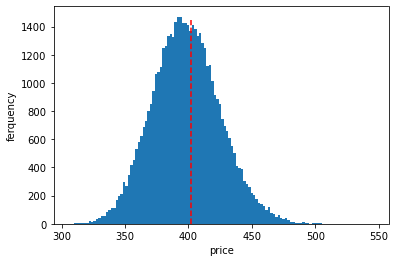

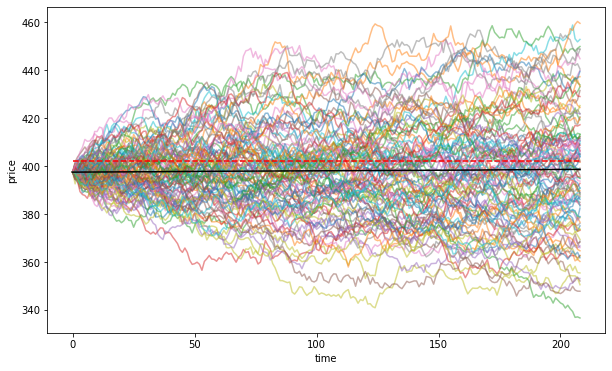

In [17]:
# S_t: the spot price of the underlying asset at time t
# r: the risk-free interest rate
# sigma: the volatility of returns of the underlying asset
# K: the strike price or exercise price of the option
# C0: the price of a European call option at time t = 0
# t: current time in years
# T: expiry or maturity date
# N: number of realizations for Monte Carlo simulation
# lognormal distribution of the price
#S0 = 404.39

S0 = 397.5
r = 0.05
sigma = 0.30
K = 402
T = .05 
N = 50000
Z = np.random.normal(size=N)
ST = S0*np.exp((r-0.5*sigma**2)*T+sigma*np.sqrt(T)*Z)  

# Monte Carlo simulation
weeks = 52 *4
dt = T/weeks  
S = np.zeros((weeks+1, N))  
S[0] = S0  
for t in range(1, weeks+1):
    Z = np.random.normal(size=N)
    S[t] = S[t-1]*np.exp((r-0.5*sigma**2)*dt+sigma*np.sqrt(dt)*Z) # Geometric Brownian Motion

plt.hist(ST, bins='auto') 
plt.vlines(K,0,1450, colors='r', linestyles='dashed', label='Strike Price')
plt.xlabel('price')
plt.ylabel('ferquency')

# plot the simulated price paths
plt.figure(figsize=(10, 6))
plt.plot(S[:, :100], alpha = 0.5)
plt.plot(S.mean(axis = 1), color='black', linewidth=1.5, label='Mean of all simulations')
# plot strike price
plt.plot(np.ones(weeks+1)*K, 'r--', label = 'Strike Price')
plt.xlabel('time')
plt.ylabel('price')

# calculate the payoff at maturity
hT = np.maximum(S[-1]-K, 0)

# calculate the Monte Carlo estimator
C0 = np.exp(-r*T)*np.sum(hT)/N
print(f"The Monte Carlo estimator of the fair-value European call option price at expiration is {C0:.3f}")

# calculate the analytical European call option price
from scipy.stats import norm
d1 = (np.log(S0/K)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
d2 = (np.log(S0/K)+(r-0.5*sigma**2)*T)/(sigma*np.sqrt(T))
C0 = (S0*norm.cdf(d1)-K*np.exp(-r*T)*norm.cdf(d2))
print(f"The analytical European call option price at expiration is {C0:.3f}")


The Monte Carlo estimator of the fair-value European call option price is 2.064
The analytical-fair-value European call option price is 2.089


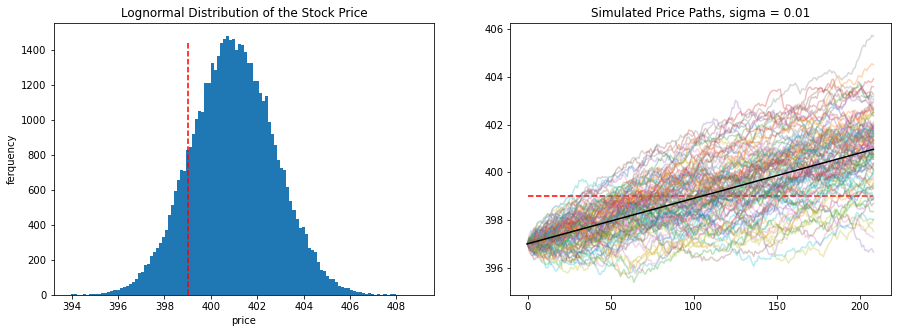

In [157]:
# S_t: the spot price of the underlying asset at time t
# r: the risk-free interest rate
# sigma: the volatility of returns of the underlying asset
# K: the strike price or exercise price of the option
# C0: the price of a European call option at time t = 0
# t: current time in years
# T: expiry or maturity date
# N: number of realizations for Monte Carlo simulation
# lognormal distribution of the price
#S0 = 404.39

S0 = 397
r = 0.05
sigma = 0.01
K = 399
T = .2
N = 50000
Z = np.random.normal(size=N)
ST = S0*np.exp((r-0.5*sigma**2)*T+sigma*np.sqrt(T)*Z) # lognormal distribution of the price

# Monte Carlo simulation of the stock price paths
weeks = 52 *4
dt = T/weeks  
S = np.zeros((weeks+1, N))  
S[0] = S0  
for t in range(1, weeks+1):
    Z = np.random.normal(size=N)
    S[t] = S[t-1]*np.exp((r-0.5*sigma**2)*dt+sigma*np.sqrt(dt)*Z) # Geometric Brownian Motion


fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].hist(ST, bins='auto')
ax[0].vlines(K,0,1450, colors='r', linestyles='dashed', label='Strike Price')
ax[0].set_title('Lognormal Distribution of the Stock Price')
ax[0].set_xlabel('price')
ax[0].set_ylabel('ferquency')

ax[1].plot(S[:, :100], alpha = 0.3)
ax[1].hlines(K,0,weeks, colors='r', linestyles='dashed', label='Strike Price')
ax[1].plot(S.mean(axis = 1), color='black', linewidth=1.5, label='Mean of all simulations')
ax[1].set_title(f'Simulated Price Paths, sigma = {sigma}')  

# calculate the payoff at maturity
hT = np.maximum(S[-1]-K, 0)

# calculate the Monte Carlo estimator
C0 = np.exp(-r*T)*np.sum(hT)/N
print(f"The Monte Carlo estimator of the fair-value European call option price is {C0:.3f}")

# calculate the analytical European call option price
from scipy.stats import norm
d1 = (np.log(S0/K)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
d2 = (np.log(S0/K)+(r-0.5*sigma**2)*T)/(sigma*np.sqrt(T))
C0 = (S0*norm.cdf(d1)-K*np.exp(-r*T)*norm.cdf(d2))
print(f"The analytical-fair-value European call option price is {C0:.3f}")


In [160]:
def mc_sim(S0 = S0, r = r, sigma = sigma, K = K, T = T, N = N):
    
    Z = np.random.normal(size=N) # Standard Normal of size N, for error term
    ST = S0*np.exp((r-0.5*sigma**2)*T+sigma*np.sqrt(T)*Z) # lognormal distribution of the price
    # Monte Carlo simulation of the stock price paths
    weeks = 52 *4
    dt = T/weeks  
    S = np.zeros((weeks+1, N))  
    S[0] = S0  
    for t in range(1, weeks+1):
        Z = np.random.normal(size=N)
        S[t] = S[t-1]*np.exp((r-0.5*sigma**2)*dt+sigma*np.sqrt(dt)*Z) # Geometric Brownian Motion


    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].hist(ST, bins='auto')
    ax[0].vlines(K,0,1450, colors='r', linestyles='dashed', label='Strike Price')
    ax[0].set_title('Lognormal Distribution of the Stock Price')
    ax[0].set_xlabel('price')
    ax[0].set_ylabel('ferquency')

    ax[1].plot(S[:, :100], alpha = 0.3)
    ax[1].hlines(K,0,weeks, colors='r', linestyles='dashed', label='Strike Price')
    ax[1].plot(S.mean(axis = 1), color='black', linewidth=1.5, label='Mean of all simulations', alpha = 0.8)
    ax[1].set_title(f'Simulated Price Paths, sigma = {sigma}')  


    # calculate the payoff at maturity
    hT = np.maximum(S[-1]-K, 0)

    # calculate the Monte Carlo estimator
    C0 = np.exp(-r*T)*np.sum(hT)/N
    print(f"The Monte Carlo estimator of the fair-value European call option price is {C0:.3f}")

    # calculate the analytical European call option price
    from scipy.stats import norm
    d1 = (np.log(S0/K)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2 = (np.log(S0/K)+(r-0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    C0 = (S0*norm.cdf(d1)-K*np.exp(-r*T)*norm.cdf(d2))
    print(f"The analytical-fair-value European call option price is {C0:.3f}")

The Monte Carlo estimator of the fair-value European call option price is 1.139
The analytical-fair-value European call option price is 1.130


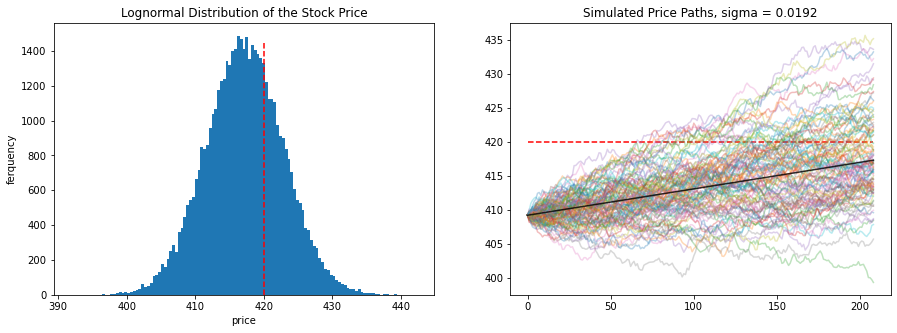

In [166]:
# S_t: the spot price of the underlying asset at time t
# r: the risk-free interest rate
# sigma: the volatility of returns of the underlying asset
# K: the strike price or exercise price of the option
# C0: the price of a European call option at time t = 0
# t: current time in years
# T: expiry or maturity date
# N: number of realizations for Monte Carlo simulation
# lognormal distribution of the price

S0 = 409.19
r = 0.039
sigma = 0.0192
K = 420
T = .5
N = 50000

mc_sim(S0, r, sigma, K, T, N)